In [2]:
import pandas as pd
from torch.utils.data import Dataset
import torch
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
import numpy as np
from tsai.all import *
from utils import  *
from sklearn.metrics import f1_score, roc_curve, auc, confusion_matrix, roc_auc_score, f1_score, accuracy_score, classification_report
import sklearn.metrics as skm
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

/home/mihai/Thesis/thesis/lib/python3.9/site-packages/tslearn/bases/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [3]:
def read_data(data_signal_string, idx=0):
    """Read data from file.
    """
    # read data from all files of CSV_data/PreviewDistractionExpData_S1/PRDCE/u.csv
    # afterwards, read changepoint detections from tc.csv, where chancging from 0 to 1 or 1 to 0 indicates a change point
    # return data, cps

    data = np.loadtxt(data_signal_string, delimiter=',')[:,idx]

    # Use regex to find the substring before the last '/'
    prefix = re.match(r'(.*)/', data_signal_string).group(1)

    # Append 'tc.csv' to the result
    tc_signal = f"{prefix}/tc.csv"

    tc = np.loadtxt(tc_signal, delimiter=',', dtype=int)[:,idx]

    cps = np.where(np.diff(tc, prepend=np.nan))[0]

    return data, cps, tc

error_signal = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/e.csv', delimiter=',')
u_signal =np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/u.csv', delimiter=',')
tc = np.loadtxt(r'/home/mihai/Thesis/Data/Clean_CSV_data/updated_data/PRDPE/mdist.csv', delimiter=',')

error_signal = error_signal[:, 0]
u_signal = u_signal[:, 0]
tc = tc[:, 0]

In [4]:
# Create feature matrix and labels
scaler = StandardScaler()
error_signal = scaler.fit_transform(error_signal.reshape(-1, 1)).flatten()
u_signal = scaler.fit_transform(u_signal.reshape(-1, 1)).flatten()

error_derivative = np.diff(error_signal)
u_signal_derivative = np.diff(u_signal)

error_derivative = scaler.fit_transform(error_derivative.reshape(-1, 1)).flatten()
u_signal_derivative = scaler.fit_transform(u_signal_derivative.reshape(-1, 1)).flatten()

X = np.column_stack((error_signal[:-1], u_signal[:-1], error_derivative, u_signal_derivative))
y = tc

In [5]:
# Convert to DataFrame
df = pd.DataFrame(X, columns=['error_signal', 'u_signal', 'error_signal_derivative', 'u_signal_derivative'])

df['label'] = y[:-1]

       error_signal
count  11999.000000
mean       0.000028
std        1.000079
min       -6.582232
25%       -0.409739
50%        0.071970
75%        0.476416
max        4.933144


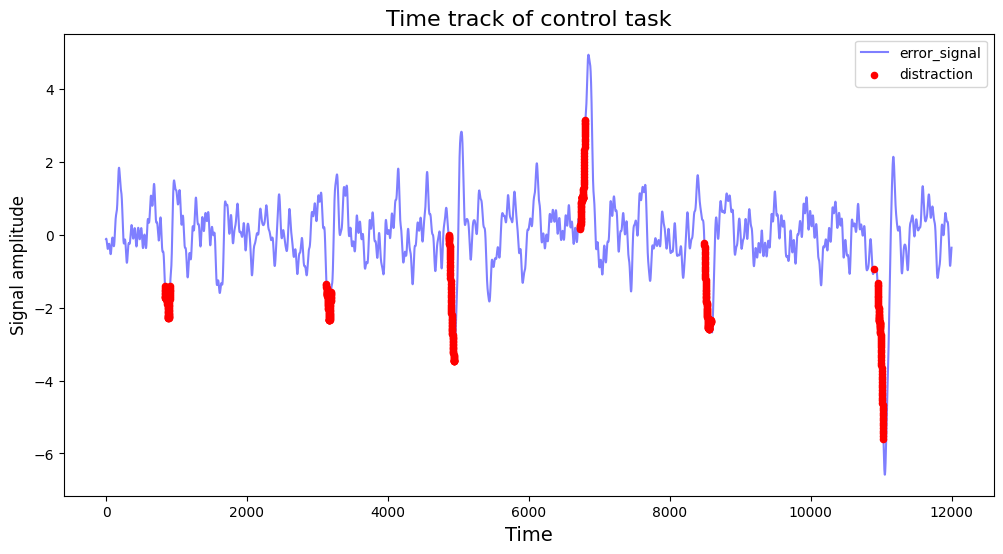

In [6]:
def plot_neutral(df):
    """
    Function: Shows summary statistics, plots neutral current
    Input: Dataframe
    Output: Plot
    """

    plt.figure(figsize=(12, 6))
    plt.xlabel('Time', fontsize=14)
    plt.ylabel('Signal amplitude', fontsize=12)
    
    print(df[['error_signal']].describe())
    
    # Define colors for the labeled and unlabeled data points
    label_color = 'red'
    other_color = 'blue'
    
    # Plot all data points with the default color
    plt.plot(df['error_signal'], label='error_signal', color=other_color, alpha=0.5)
    
    # Highlight data points corresponding to the label with smaller scatter points
    plt.scatter(df.index[df['label'] == 1], df['error_signal'][df['label'] == 1], 
                color=label_color, label='distraction', s=20, zorder=5)
    
    plt.title('Time track of control task', fontsize=16)
    plt.legend() 
    plt.show()


plot_neutral(df)

Text(0.5, 1.0, 'Lag in time-series')

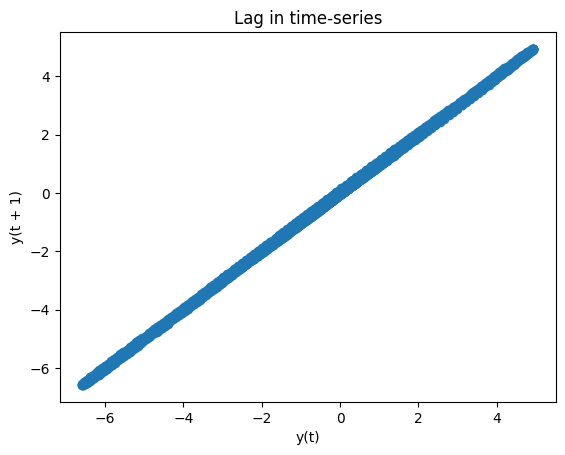

In [7]:
pd.plotting.lag_plot(df['error_signal'])
plt.title('Lag in time-series')

## Choose features

In [8]:
features = ['error_signal', 'u_signal', 'error_signal_derivative', 'u_signal_derivative']

In [9]:
contamination = np.sum(y) / len(y)
model = IsolationForest(random_state = 0, contamination = contamination)
model.fit(df[features])

IsolationForest(contamination=0.03966666666666667, random_state=0)

In [10]:
df['score'] = model.decision_function(df[features])
df['anomaly_value'] = model.predict(df[features])

df['anomaly_value_binary'] = np.where(df['anomaly_value'] == -1, 1, 0)
df.head()

,error_signal,u_signal,error_signal_derivative,u_signal_derivative,label,score,anomaly_value,anomaly_value_binary
0,-0.120070,-0.446433,0.222116,0.233463,0.0,0.183270,1,0
1,-0.113483,-0.439004,0.104902,0.241430,0.0,0.183912,1,0
2,-0.110382,-0.431322,-0.007322,0.186383,0.0,0.181778,1,0
3,-0.110618,-0.425393,-0.115220,0.192902,0.0,0.183719,1,0
4,-0.114062,-0.419256,-0.215521,0.156687,0.0,0.187897,1,0


anomaly_value_binary
0    11523
1      476
Name: count, dtype: int64


Text(0.5, 1.0, 'Isolation Forest with 5% contamination')

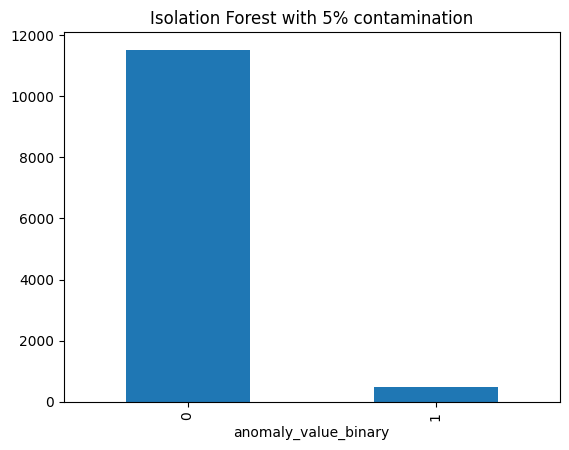

In [11]:
outliers = df.loc[df['anomaly_value_binary'] == 1]
outlier_index = list(outliers.index)

#datapoints classified -1 are anomalous
print(df['anomaly_value_binary'].value_counts())
df['anomaly_value_binary'].value_counts().plot(kind = 'bar')
plt.title('Isolation Forest with 5% contamination')

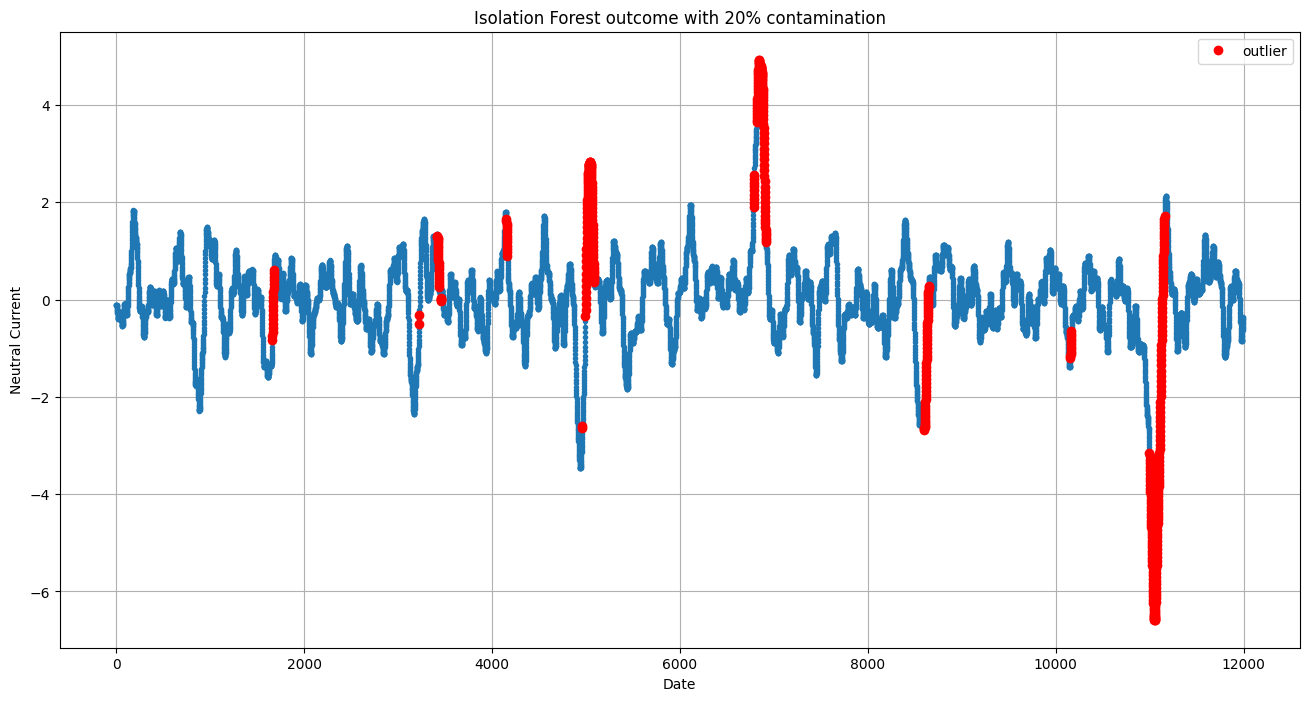

In [12]:
plt.figure(figsize = (16, 8))

plt.plot(df['error_signal'], marker = '.')
plt.plot(outliers['error_signal'], 'o', color = 'red', label = 'outlier')
plt.title('Isolation Forest outcome with 20% contamination')
plt.grid()
plt.xlabel('Date')
plt.ylabel('Neutral Current')
plt.legend()

In [13]:
# Calculate metrics
y_true = df['label']
y_pred = df['anomaly_value_binary']

# Compute AUC
auc_score = roc_auc_score(y_true, y_pred)
print(f"AUC: {auc_score:.2f}")

# Compute F1 Score
f1 = f1_score(y_true, y_pred)
print(f"F1 Score: {f1:.2f}")

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Print a detailed classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)

AUC: 0.53
F1 Score: 0.09
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96     11523
         1.0       0.09      0.09      0.09       476

    accuracy                           0.93     11999
   macro avg       0.53      0.53      0.53     11999
weighted avg       0.93      0.93      0.93     11999



In [14]:
print('Done!')

Done!


## Use windowed data

In [15]:
def create_windowed_data(df, features, labels, window_size, overlap, anomaly_threshold=10):
    """
    Creates windowed data with overlap.
    
    Parameters:
    - df: The original DataFrame.
    - features: List of columns to use as features.
    - window_size: The size of each window.
    - overlap: The number of overlapping points between consecutive windows.
    
    Returns:
    - windowed_data: A 2D array where each row is a flattened window.
    """
    step_size = window_size - overlap
    windows = []
    window_labels = []
    
    for start in range(0, len(df) - window_size + 1, step_size):
        window = df[features].iloc[start:start + window_size].values.flatten()
        windows.append(window)
        
        # Aggregate labels: If any point in the window is an anomaly, label the entire window as an anomaly
        anomaly_count = np.sum(labels[start:start + window_size] == 1)
        
        if anomaly_count > anomaly_threshold:
            window_labels.append(1)
        else:
            window_labels.append(0)
    
    return np.array(windows), np.array(window_labels)


# Example usage:
window_size = 50
overlap = 25
anomaly_threshold = 5

windowed_data, windowed_labels = create_windowed_data(df, features, df['label'].values, window_size, overlap, anomaly_threshold)

print(windowed_data.shape)

(478, 200)


In [16]:
model2 = IsolationForest(random_state=0, contamination=contamination)

# Fit the model on the windowed data
model2.fit(windowed_data)

# Predict anomalies
anomaly_scores2 = model2.decision_function(windowed_data)
anomalies2 = model2.predict(windowed_data)

threshold = 0.05
anomaly_scores2_binary = np.where(anomaly_scores2 < threshold, 1, 0) 

In [17]:
# compute performance metrics
accuracy = accuracy_score(windowed_labels, anomaly_scores2_binary)
f1 = f1_score(windowed_labels, anomaly_scores2_binary)
auc = roc_auc_score(windowed_labels, anomaly_scores2)
report = classification_report(windowed_labels, anomaly_scores2_binary)

print(f'Accuracy: {accuracy}')
print(f'F1 Score: {f1}')
print(f'AUC: {auc}')
print("Classification Report:")
print(report)

Accuracy: 0.8828451882845189
F1 Score: 0.24324324324324326
AUC: 0.19691267951770217
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.92      0.94       449
           1       0.20      0.31      0.24        29

    accuracy                           0.88       478
   macro avg       0.58      0.62      0.59       478
weighted avg       0.91      0.88      0.89       478



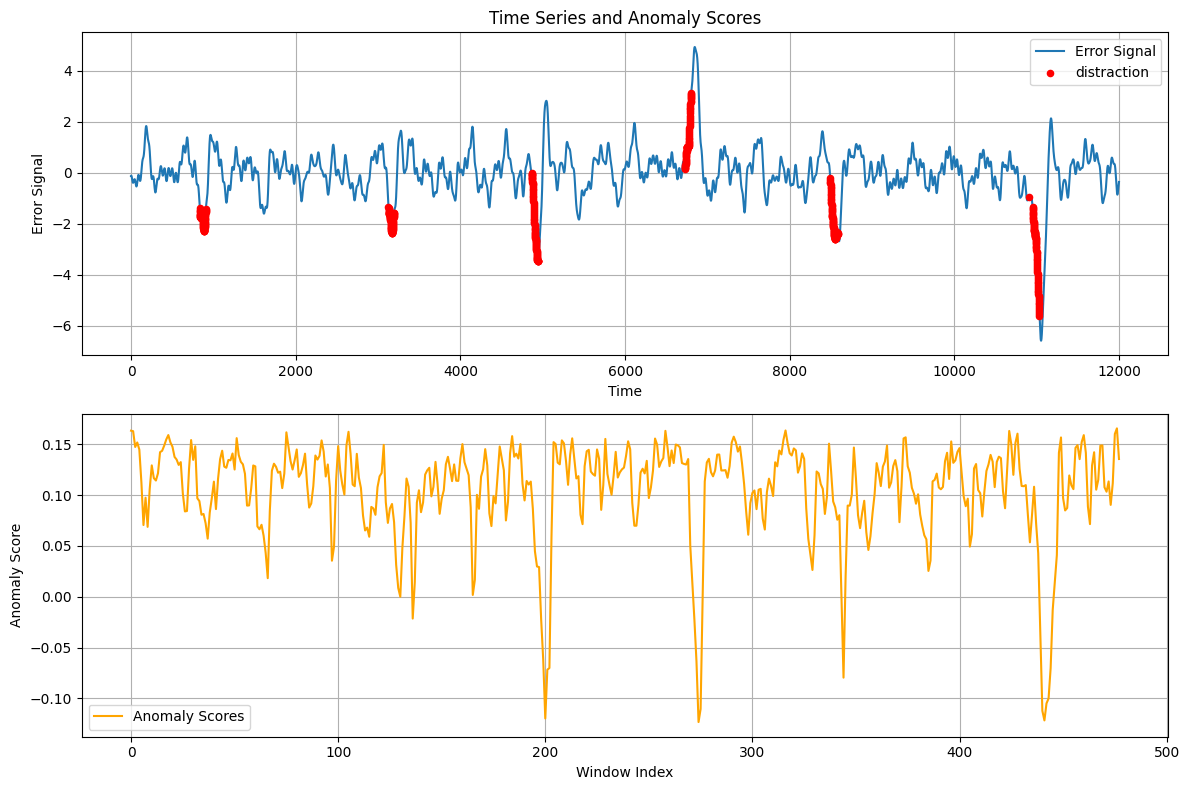

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(df['error_signal'], label='Error Signal')
plt.scatter(df.index[df['label'] == 1], df['error_signal'][df['label'] == 1], 
                color='red', label='distraction', s=20, zorder=5)
plt.grid()
plt.xlabel('Time')
plt.ylabel('Error Signal')
plt.title('Time Series and Anomaly Scores')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(anomaly_scores2, label='Anomaly Scores', color='orange')
plt.grid()
plt.xlabel('Window Index')
plt.ylabel('Anomaly Score')
plt.legend()

plt.tight_layout()
plt.show()

## Visualisation

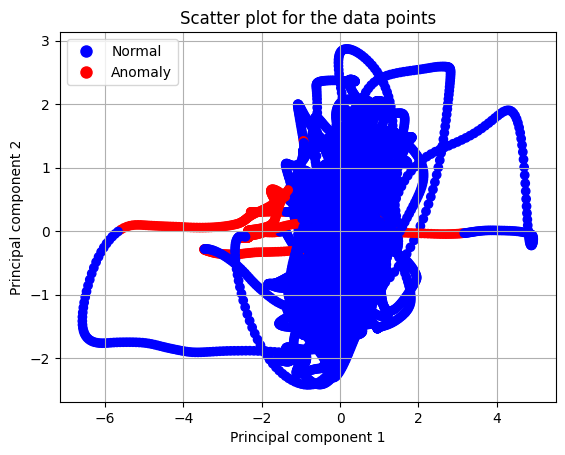

In [19]:
from sklearn.decomposition import PCA
pca = PCA(2)
x_pca = pca.fit_transform(df)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
cdict = {0: 'blue', 1: 'red'}
plt.scatter(X[:, 0], X[:, 1], c=[cdict[label] for label in y[:-1]], alpha=1)
plt.title('Scatter plot for the data points')
plt.xlabel('Principal component 1') 
plt.grid()
plt.ylabel('Principal component 2') 
labels = ['Normal', 'Anomaly'] 
colors = [cdict[0], cdict[1]]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]

plt.legend(handles, labels, loc='best')

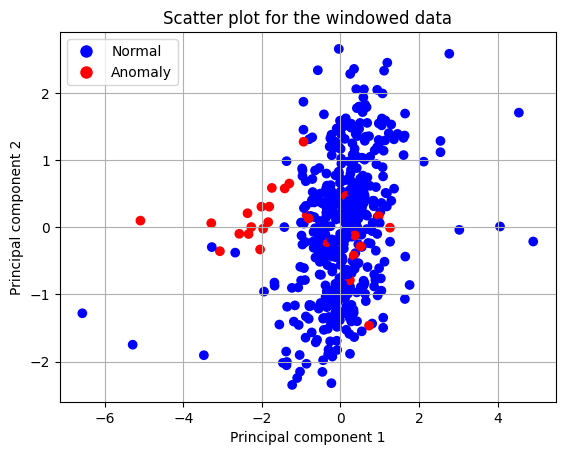

In [20]:
pca = PCA(2)
x_pca = pca.fit_transform(windowed_data)
x_pca = pd.DataFrame(x_pca)
x_pca.columns=['PC1','PC2']
cdict = {0: 'blue', 1: 'red'}
plt.scatter(windowed_data[:, 0], windowed_data[:, 1], c=[cdict[label] for label in windowed_labels], alpha=1)
plt.title('Scatter plot for the windowed data')
plt.grid()
plt.xlabel('Principal component 1') 
plt.ylabel('Principal component 2') 
labels = ['Normal', 'Anomaly'] 
colors = [cdict[0], cdict[1]]
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in colors]

plt.legend(handles, labels, loc='best')

## Try KNN


In [21]:
window_size = 25
overlap = 5
anomaly_threshold = 10

windowed_data, windowed_labels = create_windowed_data(df, features, df['label'].values, window_size, overlap, anomaly_threshold)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(windowed_data, windowed_labels, test_size=0.9, random_state=42)

# Create a KNN classifier using Dynamic Time Warping (DTW) as the distance metric
knn_dtw = KNeighborsTimeSeriesClassifier(n_neighbors=3, metric="dtw")

# Fit the classifier on the training data
knn_dtw.fit(X_train, y_train)

# Predict the labels for the test data
y_pred = knn_dtw.predict(X_test)

# Evaluate the classifier
print(classification_report(y_test, y_pred))
print(f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98       517
           1       1.00      0.04      0.08        23

    accuracy                           0.96       540
   macro avg       0.98      0.52      0.53       540
weighted avg       0.96      0.96      0.94       540

0.08333333333333333


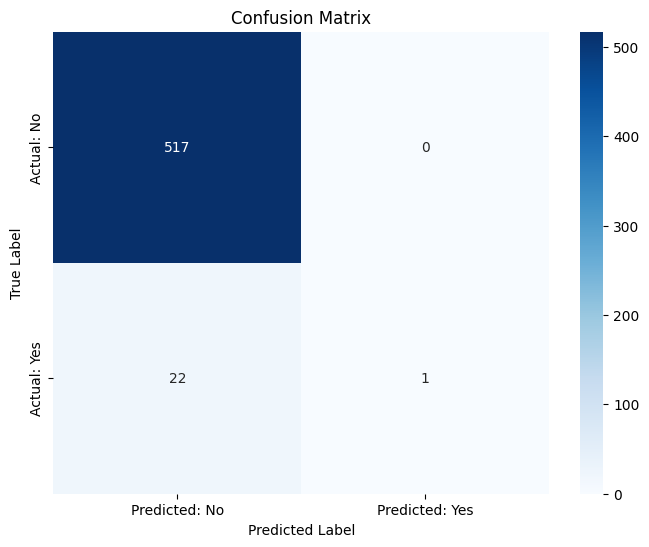

In [22]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred))